# Stock Market Prediction using Stacked LSTM
**Objective:** To predict the future closing stock price of Titan Company Ltd. (TITAN.NS) using historical data. 
We will use a **Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM)** layers, which is highly effective for time-series forecasting.

## 1. Data Collection
We will use the `yfinance` library to fetch the last 5 years of daily historical stock data for Titan Company Ltd. from the National Stock Exchange (NSE).

In [2]:
import yfinance as yf
from datetime import date, timedelta

end = date.today()
start = end - timedelta(days=5*365)

ticker = yf.Ticker("TITAN.NS")  # Titan on NSE
df = ticker.history(start=start, end=end, interval="1d")

## 2. Data Exploration
Let's visualize the historical closing price. As observed, the data shows an overall uptrend, meaning the mean and variance are not constant over time (the data is non-stationary).

In [7]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-02-15 00:00:00+05:30,1482.934799,1495.243354,1454.132778,1462.010254,3156535,0.0,0.0
2021-02-16 00:00:00+05:30,1469.297252,1481.950426,1438.624301,1449.308105,3090249,0.0,0.0
2021-02-17 00:00:00+05:30,1446.895609,1460.287296,1427.300361,1438.033447,2096959,0.0,0.0
2021-02-18 00:00:00+05:30,1442.661454,1449.357357,1407.114362,1411.053101,2686046,0.0,0.0
2021-02-19 00:00:00+05:30,1412.037823,1422.770910,1391.162556,1403.717285,2543997,0.0,0.0


In [8]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-02-05 00:00:00+05:30,4152.299805,4152.299805,4063.100098,4097.600098,693637,0.0,0.0
2026-02-06 00:00:00+05:30,4097.600098,4154.000000,4065.300049,4141.000000,888701,0.0,0.0
2026-02-09 00:00:00+05:30,4200.200195,4269.399902,4155.000000,4257.799805,1092387,0.0,0.0
2026-02-10 00:00:00+05:30,4300.000000,4329.600098,4239.600098,4269.100098,1713633,0.0,0.0
2026-02-11 00:00:00+05:30,4350.000000,4378.399902,4208.000000,4249.100098,3342226,0.0,0.0


In [5]:
df1=df.reset_index()['Close']

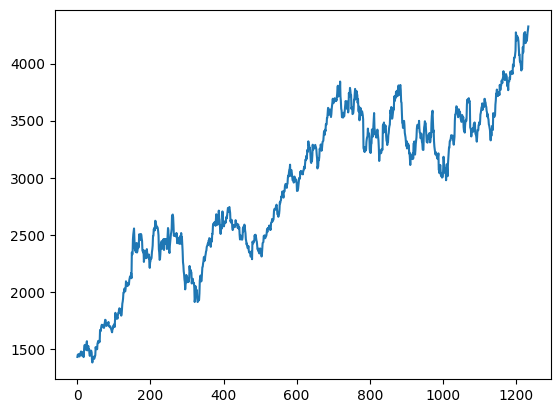

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

 The data shows an overall uptrend.
The mean and variance are not constant, meaning the data is non-stationary.

## 3. Data Preprocessing
LSTMs are highly sensitive to the scale of the input data. We will use `MinMaxScaler` to scale the closing prices down to a range between 0 and 1.

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
print(df1)

[[0.01647501]
 [0.02283086]
 [0.02398501]
 ...
 [0.98223262]
 [0.98963849]
 [1.        ]]


## 4. Train-Test Split
For time-series data, we cannot use a random split. We must split the data sequentially. We will use 75% of the oldest data for training the model and the remaining 25% for testing its predictive accuracy.

In [11]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
training_size,test_size

(926, 309)

## 5. Creating Sequences (Time-Steps)
LSTMs require sequential input. We will structure our dataset so that the model looks at the past 100 days (`time_step = 100`) to predict the price of the 101st day.

In [14]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape)

(825, 100)
(825,)


(None, None)

In [18]:
print(X_test.shape), print(ytest.shape)

(208, 100)
(208,)


(None, None)

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## 6. Building the Stacked LSTM Model
We will build a Stacked LSTM network consisting of three LSTM layers (50 units each) followed by a Dense layer. 
* **Optimizer:** Adam
* **Loss Function:** Mean Squared Error (MSE)

In [20]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

C:\Users\Asus\anaconda\envs\my_new_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Model Training
We will now train the Stacked LSTM model using our training data. We use `epochs=100` (number of times the learning algorithm will work through the entire training dataset) and `batch_size=64` (number of samples to work through before updating the internal model parameters).

In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.0000e+00 - loss: 0.0577 - val_accuracy: 0.0000e+00 - val_loss: 0.0757
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0000e+00 - loss: 0.0121 - val_accuracy: 0.0000e+00 - val_loss: 0.0037
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0000e+00 - loss: 0.0049 - val_accuracy: 0.0000e+00 - val_loss: 0.0060
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0000e+00 - loss: 0.0030 - val_accuracy: 0.0000e+00 - val_loss: 0.0074
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.0000e+00 - loss: 0.0021 - val_accuracy: 0.0000e+00 - val_loss: 0.0040
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0000e+00 - loss: 0.0020 - val_accuracy: 0.0000e+00 - val_loss: 0.0040
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.0000e+00 - loss: 0.0019 - val_accuracy: 0.0000e+00 - val_loss: 0.0033
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/s

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## 8. Making Predictions & Inverse Transformation
Once the model is trained, we use it to predict the stock prices for both the training and testing datasets. 

Since we scaled our data down to a `(0, 1)` range during preprocessing, the model's predictions are also in this scaled format. We must use `scaler.inverse_transform()` to convert these predictions back to the original, real-world stock price values.

In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

2881.8706478900112

## 9. Performance Evaluation
To quantify our model's accuracy, we will calculate the **Root Mean Squared Error (RMSE)** for both the training and testing predictions. RMSE measures the average magnitude of the errors between the predicted values and the actual values. A lower RMSE indicates a better fit.

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

3701.324444068177

## 10. Visualizing Predictions vs. Actual Data
Now, we will plot the data to visually compare how well our model performed. 
By comparing the test predictions with the actual test data, we can see how well the model generalizes to new, unseen market data.

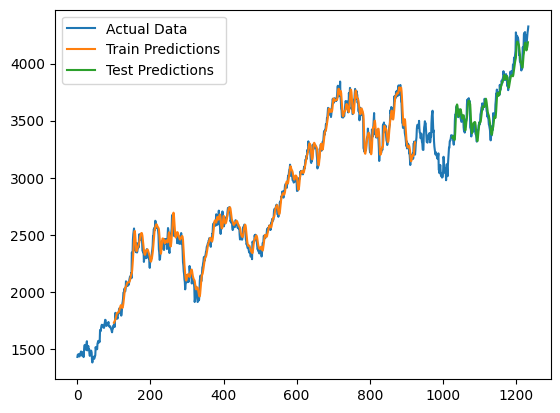

In [28]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()

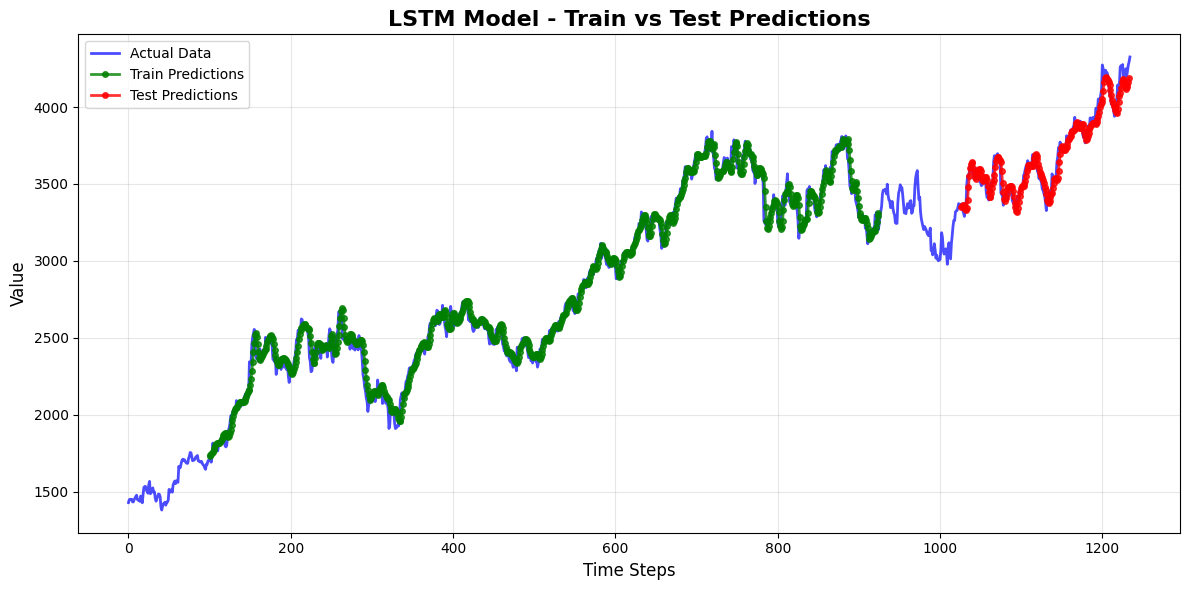

In [29]:
### Plotting 
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions with modern style
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), 'b-', linewidth=2, label='Actual Data', alpha=0.7)
plt.plot(trainPredictPlot, 'go-', linewidth=2, markersize=4, label='Train Predictions', alpha=0.8)
plt.plot(testPredictPlot, 'ro-', linewidth=2, markersize=4, label='Test Predictions', alpha=0.8)
plt.title('LSTM Model - Train vs Test Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
len(test_data)

309

## 11. Forecasting Future Prices (Next 20 Days)
Finally, we will use our trained model to forecast the stock's closing price for the next 30 days. We extract the last 100 days of data from our dataset to act as the initial input sequence for predicting the first future day, and then iteratively predict the subsequent days.

In [31]:
# ========================================
# PREDICT NEXT 20 DAYS
# ========================================
scaled_data = df1
# Get last 100 days of scaled data
last_100_days = scaled_data[-100:]
future_predictions = []

# Predict next 20 days
for i in range(20):
    input_data = last_100_days.reshape(1, 100, 1)
    next_pred = model.predict(input_data, verbose=0)
    future_predictions.append(next_pred[0, 0])
    last_100_days = np.append(last_100_days[1:], next_pred).reshape(-1, 1)

# Convert predictions back to actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(20)]

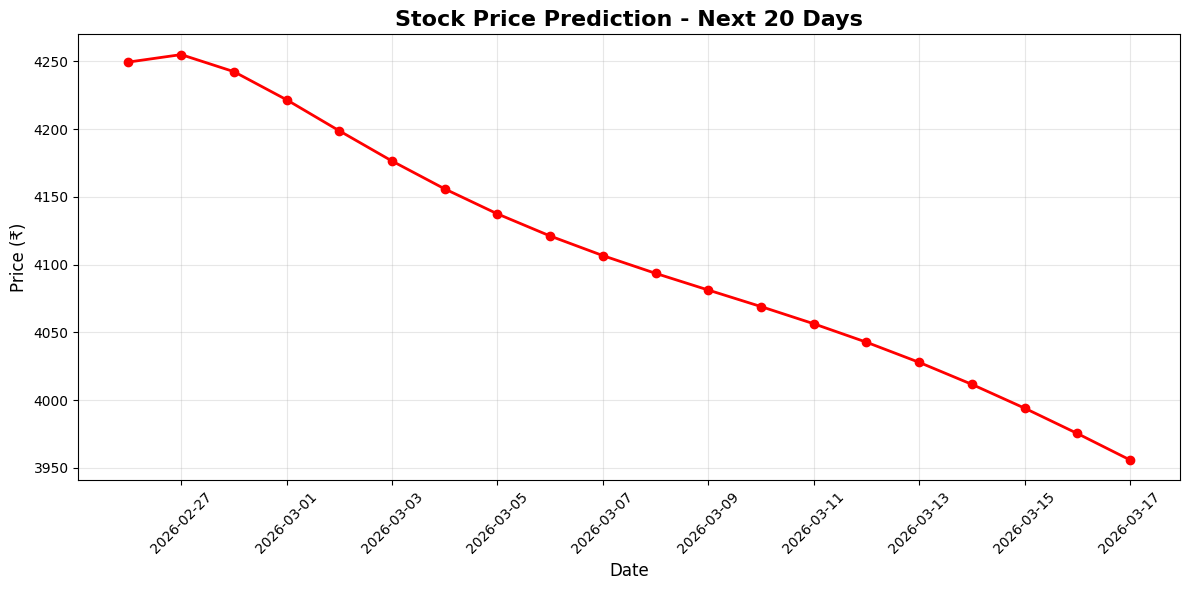

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, 'ro-', linewidth=2, markersize=6)
plt.title('Stock Price Prediction - Next 20 Days', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (₹)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

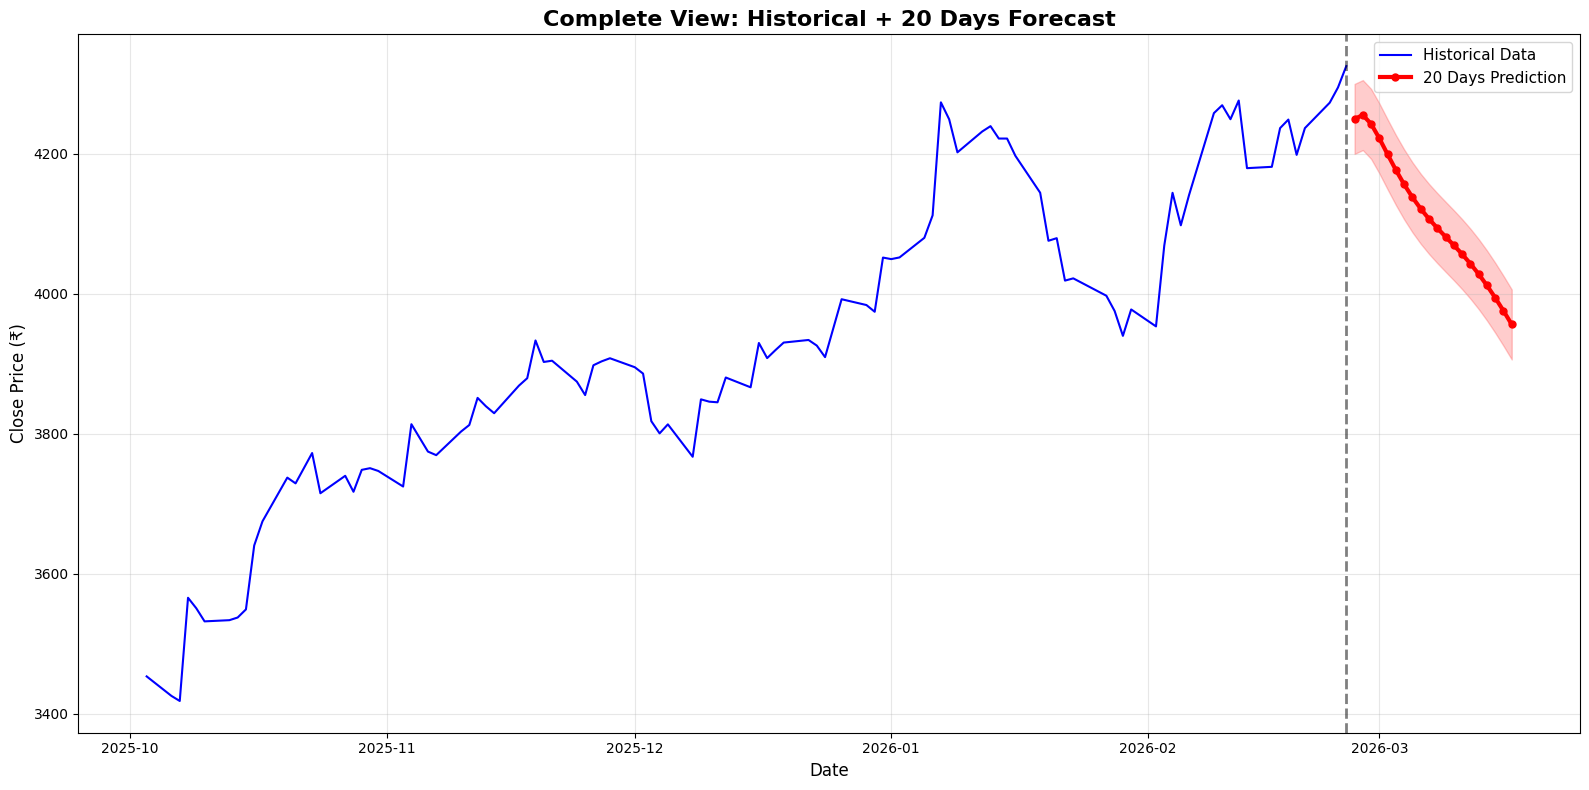

In [33]:
plt.figure(figsize=(16, 8))

# Plot last 100 days of historical data
recent = df['Close'].tail(100)
plt.plot(recent.index, recent.values, 'b-', label='Historical Data', linewidth=1.5)

# Plot future predictions (highlighted)
plt.plot(future_dates, future_predictions, 'r-', linewidth=3, 
         label='20 Days Prediction', marker='o', markersize=5)

# Add vertical line at today
plt.axvline(x=last_date, color='black', linestyle='--', linewidth=2, alpha=0.5)

# Highlight prediction area
plt.fill_between(future_dates, 
                 future_predictions.flatten() - 50, 
                 future_predictions.flatten() + 50, 
                 alpha=0.2, color='red')

plt.title('Complete View: Historical + 20 Days Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (₹)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
print("\n" + "="*60)
print("NEXT 20 DAYS PREDICTIONS")
print("="*60)
for i, (date_val, price) in enumerate(zip(future_dates, future_predictions.flatten()), 1):
    print(f"Day {i:2d} | {date_val.strftime('%Y-%m-%d')} | ₹{price:.2f}")
print("="*60)

current_price = df['Close'].iloc[-1]
print(f"\nCurrent Price: ₹{current_price:.2f}")
print(f"Predicted (Day 20): ₹{future_predictions[-1][0]:.2f}")
change = future_predictions[-1][0] - current_price
print(f"Expected Change: ₹{change:.2f} ({(change/current_price*100):.2f}%)")


NEXT 20 DAYS PREDICTIONS
Day  1 | 2026-02-26 | ₹4249.51
Day  2 | 2026-02-27 | ₹4255.01
Day  3 | 2026-02-28 | ₹4242.43
Day  4 | 2026-03-01 | ₹4221.69
Day  5 | 2026-03-02 | ₹4198.77
Day  6 | 2026-03-03 | ₹4176.47
Day  7 | 2026-03-04 | ₹4155.91
Day  8 | 2026-03-05 | ₹4137.47
Day  9 | 2026-03-06 | ₹4121.16
Day 10 | 2026-03-07 | ₹4106.69
Day 11 | 2026-03-08 | ₹4093.60
Day 12 | 2026-03-09 | ₹4081.28
Day 13 | 2026-03-10 | ₹4069.07
Day 14 | 2026-03-11 | ₹4056.40
Day 15 | 2026-03-12 | ₹4042.79
Day 16 | 2026-03-13 | ₹4027.93
Day 17 | 2026-03-14 | ₹4011.70
Day 18 | 2026-03-15 | ₹3994.14
Day 19 | 2026-03-16 | ₹3975.45
Day 20 | 2026-03-17 | ₹3955.92

Current Price: ₹4325.00
Predicted (Day 20): ₹3955.92
Expected Change: ₹-369.08 (-8.53%)
